# Preparation

In [1]:
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from typing import List, Tuple

In [2]:
TRAIN_DIR = "../../datasets/malang_images/training"
TEST_DIR = "../../datasets/malang_images/test"

In [3]:
# Set random seed for reproducibility
def set_seed(seed) -> None:
    random.seed(seed)
    np.random.seed(seed)

RANDOM_SEED = 4
set_seed(seed=RANDOM_SEED)

# Load Dataset

In [4]:
def load_dataset(img_dir: str) -> List[Tuple[np.ndarray, str]]:
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list: List[Tuple[np.ndarray, str]] = []

    for dir in dirs:
        label = str(dir).split('/')[-1]
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [5]:
train_img = load_dataset(TRAIN_DIR)

In [6]:
train_img[0]

(array([[[158, 194, 218],
         [158, 194, 218],
         [158, 194, 218],
         ...,
         [176, 209, 228],
         [177, 210, 229],
         [177, 210, 229]],
 
        [[158, 194, 218],
         [158, 194, 218],
         [158, 194, 218],
         ...,
         [180, 213, 232],
         [180, 213, 232],
         [180, 213, 232]],
 
        [[158, 194, 218],
         [158, 194, 218],
         [158, 194, 218],
         ...,
         [177, 210, 229],
         [177, 210, 229],
         [177, 210, 229]],
 
        ...,
 
        [[ 35,  40,  43],
         [ 38,  43,  46],
         [ 39,  44,  47],
         ...,
         [ 65,  73,  75],
         [ 65,  73,  75],
         [ 65,  73,  75]],
 
        [[ 36,  41,  44],
         [ 38,  43,  46],
         [ 39,  44,  47],
         ...,
         [ 68,  76,  78],
         [ 68,  76,  78],
         [ 65,  73,  75]],
 
        [[ 36,  41,  44],
         [ 38,  43,  46],
         [ 39,  44,  47],
         ...,
         [ 68,  76,  78],
  

In [7]:
# Random size checking
pick_random = np.random.randint(0, len(train_img))

# Check img size
print(f'Image {pick_random}')
print(train_img[pick_random][0].shape)

Image 122
(737, 1024, 3)


Shape	: (555, 800, 3)
Label	: ..\..\datasets\malang_images\training\night


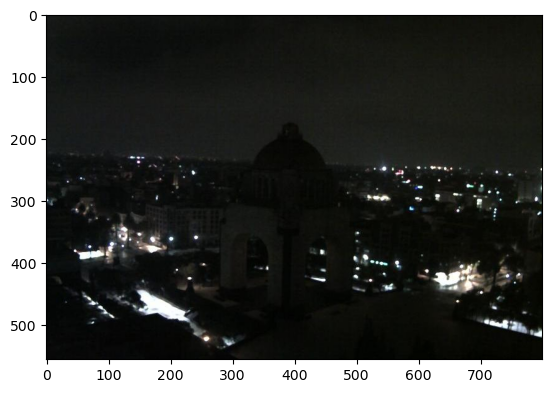

In [8]:
def random_img_viz(img_list: List[Tuple[np.ndarray, str]]) -> None:
    rand_num = np.random.randint(0, len(img_list))

    img = img_list[rand_num][0]
    label = img_list[rand_num][1]
    label_str = 'day' if label == 1 else 'night'

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')

random_img_viz(train_img)

# Data Preprocessing

## Utility Functions

In [9]:
def standarized_input(image: np.ndarray) -> np.ndarray:
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img

def label_encoder(label: str) -> int:
    # Encode the label
    # day as 1; night as 0
    num_val = 0

    if(label == 'day'):
        num_val = 1
    
    return num_val

def preprocess(
    img_list: List[Tuple[np.ndarray, str]]
) -> List[Tuple[np.ndarray, int]]:
    std_img_list = []

    for item in img_list:
        image = item[0]
        label = item[1]

        # Standarized the image
        std_img = standarized_input(image)

        # Create the label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))
    
    return std_img_list

## Preprocessing Execution

In [10]:
train_std_img_list = preprocess(train_img)

In [11]:
# Random size checking
pick_random = np.random.randint(0, len(train_std_img_list))

# Check img size
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 183
(600, 1100, 3)


# Feature Extraction

In [12]:
def avg_brightness(image: np.ndarray) -> float:
    # Convert image to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate the avg of brightness
    sum_brightness = np.sum(img_hsv[:,:,2]) # take the 3rb value which is the V channel
    area = image.shape[0] * image.shape[1]
    avg = sum_brightness / area

    return avg

Image 197
Avg Brighness: 99.5147


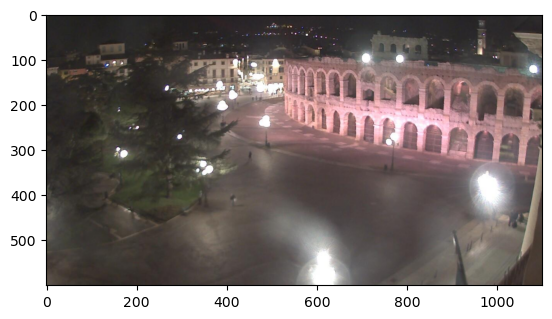

In [13]:
# Check on random image
rand_img = np.random.randint(0, len(train_std_img_list))

feature_img = train_std_img_list[rand_img][0]

avg_img = avg_brightness(feature_img)

print(f'Image {rand_img}')
print(f'Avg Brighness: {avg_img:.4f}')
plt.imshow(feature_img)

# Image Classification with Threshold

In [14]:
def predict_label(
    img: np.ndarray, 
    threshold: float
) -> int:
    # Computer average brightness
    avg = avg_brightness(img)
    pred = 0

    # Predict the label based on user defined threshold
    if avg > threshold:
        pred = 1
    
    return pred

Image 129
Actual label: 0
Predicted label: 0


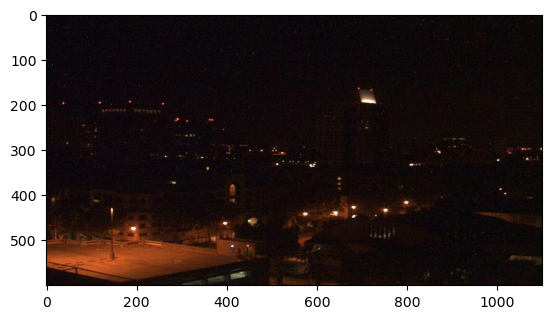

In [15]:
# Test the classifier on train data
rand_img = np.random.randint(0, len(train_std_img_list))

pred = predict_label(train_std_img_list[rand_img][0], threshold=120)

# Evaluate
print(f'Image {rand_img}')
print(f'Actual label: {train_std_img_list[rand_img][1]}')
print(f'Predicted label: {pred}')
plt.imshow(train_std_img_list[rand_img][0])

# Manual Evaluation

In [16]:
def evaluate(
    img_list: List[Tuple[np.ndarray, int]],
    threshold: float
) -> None:
    miss_labels = []

    for file in img_list:
        # Get the ground truth / correct label
        img = file[0]
        label = file[1]

        # Get prediction
        pred_label = predict_label(img, threshold)

        # Compare ground truth and pred
        if pred_label != label:
            miss_labels.append((img, pred_label, label))
    
    total_img = len(img_list)
    corr_pred = total_img - len(miss_labels)
    accuracy = corr_pred / total_img

    print(f'Accuracy: {accuracy:.4f}')

evaluate(train_std_img_list, threshold=120)

Accuracy: 0.6583


In [17]:
test_img = load_dataset(TEST_DIR)

test_std_img_list = preprocess(test_img)

evaluate(test_std_img_list, threshold=120)

Accuracy: 0.6062


# Classification with SVM

In [18]:
def extract_avg_bright_feature(
    img_list: List[Tuple[np.ndarray, int]],
) -> pd.DataFrame:
    avg_list = []
    labels = []

    for img in img_list:
        img_avg = avg_brightness(img[0]) # Get the avg brightness from image
        img_label = predict_label(img[0], threshold=120)

        avg_list.append(img_avg)
        labels.append(img_label)
    
    # Stack data in columcular way
    data = np.column_stack((avg_list, labels))
    # Create a Pandas dataframe
    df = pd.DataFrame(data, columns=['AVG_BRIGHT', 'LABELS'])

    return df

In [19]:
# Extract feature on train data
train_avg_img = extract_avg_bright_feature(train_std_img_list)
print(f'Shape: {train_avg_img.shape}')
train_avg_img.head()

Shape: (240, 2)


,AVG_BRIGHT,LABELS
0,175.092992,1.0
1,192.907867,1.0
2,132.133823,1.0
3,199.749191,1.0
4,109.947203,0.0


In [20]:
train_avg_img['LABELS'].unique()

array([1., 0.])

In [21]:
# Do the same thing on test data
test_avg_img = extract_avg_bright_feature(test_std_img_list)
print(f'Shape: {test_avg_img.shape}')
test_avg_img.head(),

Shape: (160, 2)


(   AVG_BRIGHT  LABELS
 0  194.228062     1.0
 1  157.826662     1.0
 2  201.607444     1.0
 3  191.237441     1.0
 4  188.119652     1.0,)

In [22]:
# Split data and label
X_train = train_avg_img.iloc[:,0].to_numpy().reshape(-1, 1)
y_train = train_avg_img.iloc[:,1]
X_test = test_avg_img.iloc[:,0].to_numpy().reshape(-1,1)
y_test = test_avg_img.iloc[:,1]

In [23]:
print(np.unique(y_train))
print(len(np.unique(y_train)))

[0. 1.]
2


## Model Definition and Training

In [24]:
model = SVC()
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## Model Evaluation

In [25]:
# Make a prediction on train data
y_train_pred = model.predict(X_train)

# Get the accuracy on train data
acc_train = accuracy_score(y_train, y_train_pred)

# Make a prediction on test data
y_test_pred = model.predict(X_test)

# Get the accuracy on test data
acc_test = accuracy_score(y_test, y_test_pred)

# Print Eval Result
print(f'Accuracy on train: {acc_train}')
print(f'Accuracy on test: {acc_test}')

Accuracy on train: 0.9958333333333333
Accuracy on test: 1.0
